<a href="https://www.kaggle.com/naelaqel/clustring-of-electricity-rates-in-us?scriptVersionId=90017144" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Before Starting ... Define 'Path' Folder

In [1]:
# Uncomment the line related to where you run this notebook
# 1. Kaggle
path = '/kaggle/input/electricity-utility-rates'

# 2. Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/......'  # Continue the path

# 3. Your PC
# path = '......'# Continue the path

# Overview
In this notebook we will analyze the US Electricity Utility Rates, the dataset is available in kaggle [here](https://www.kaggle.com/pseudoproton/electricity-utility-rates) and contains these columns:
1. **`zip`**: Area zip code.
2. **`eiaid`**: Energy Information Administration ID.
3. **`utility_name`**: Utility company name.
4. **`state`**: State in US.
5. **`service_type`**: Service type, it has 3 values ('Bundled', 'Delivery', 'Energy').
6. **`ownership`**: Has one value only (Investor Owned).
7. **`comm_rate`**: Commercial rate (\$/KWH).
8. **`ind_rate`**: Industrial rate (\$/KWH).
9. **`res_rate`**: Residential rate (\$/KWH).

**Note**: No documentation provided in the dataset details, some information provided in the description above are by guessing. 

# Summary

Through this notebook we:
1. Clean and Preperaing the data in the dataset.
2. Extracting location features.
3. Adding scores based on rates.
4. EDA for features.
5. Running unsupervised clustering model to group the rates.
6. Geo-visualization of the clustered rate groups.
7. Generating a summary dataset of cluster groups based on the features.

**Hope you enjoy reading, and feel free to leave your feedback, thank you :)**

# 01 Data Preperation

## 01.01 Importing Modules and Set Parameters

In [2]:
# Import modules 
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import re 
import requests
from zipfile import ZipFile
from io import BytesIO
from sklearn.cluster import KMeans

# Set plot style, size, context and palette
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (30,15)
sns.set_context('poster')
sns.set_palette('colorblind') 

## 01.02 Loading and Looking in Dataset Information

In [3]:
# Load and see first rows in the dataset
df = pd.read_csv(path + '/electricity_utility_rates.csv')

df.head()

,zip,eiaid,utility_name,state,service_type,ownership,comm_rate,ind_rate,res_rate
0,35218,195,Alabama Power Co,AL,Bundled,Investor Owned,0.105761,0.060292,0.114943
1,35219,195,Alabama Power Co,AL,Bundled,Investor Owned,0.105761,0.060292,0.114943
2,35214,195,Alabama Power Co,AL,Bundled,Investor Owned,0.105761,0.060292,0.114943
3,35215,195,Alabama Power Co,AL,Bundled,Investor Owned,0.105761,0.060292,0.114943
4,35216,195,Alabama Power Co,AL,Bundled,Investor Owned,0.105761,0.060292,0.114943


In [4]:
# See dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37791 entries, 0 to 37790
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   zip           37791 non-null  int64  
 1   eiaid         37791 non-null  int64  
 2   utility_name  37791 non-null  object 
 3   state         37791 non-null  object 
 4   service_type  37791 non-null  object 
 5   ownership     37791 non-null  object 
 6   comm_rate     37791 non-null  float64
 7   ind_rate      37791 non-null  float64
 8   res_rate      37791 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.6+ MB


We have `37791` rows of data, also no missing values and data types are correct, that's great.

## 01.03 Cleaning Dataset

### 01.03.01 Checking Rows Duplication

In [5]:
# See how namy rows are duplicated
df.duplicated().sum()

0

Great, no duplication rows.

### 01.03.02 Reviewing Numerical Columns

Using `describe()` function, we will see a summery review of the numerical columns for any wrong values (examples: all rates, eiaid and zip code can't be negative, ...)

In [6]:
df.describe()

,zip,eiaid,comm_rate,ind_rate,res_rate
count,37791.000000,37791.000000,37791.000000,37791.000000,37791.000000
mean,41699.418539,12204.586568,0.084026,0.063159,0.103371
std,30368.453729,8304.454501,0.044443,0.047204,0.046898
min,1001.000000,195.000000,0.000000,0.000000,0.000000
25%,15526.000000,5109.000000,0.055580,0.036561,0.080246
50%,33702.000000,13573.000000,0.081872,0.059807,0.103703
75%,63143.500000,15270.000000,0.108714,0.078898,0.134361
max,99950.000000,55937.000000,0.839779,0.668639,0.849873


We can see that:
1. `zip` and `eiaid` don't have any negative values, also it dosn't have any (`0`) value, so these values are correct.
2. All `rate` columns seems to be normal, no negative values, and ranges seems to be ok.
3. The `0` value in `rate`s indicates that the `utility` is not providing service in this sector, we can assume that a particular row is missing of all `rate`s values are `0`, let's check it.

In [7]:
# we will see how many rows has 0 rate for all rates
len(df[(df['comm_rate'] == 0) & (df['ind_rate'] == 0) & (df['res_rate'] == 0)])

0

Rows are ok, but to not effecting our statistical calculations, we have to change the values of `0` to `Nan`.

In [8]:
df.replace(to_replace={'comm_rate':{0:np.nan}, 'ind_rate':{0:np.nan}, 'res_rate':{0:np.nan}},
          inplace=True)

# Lets see hiw many rate values become `nan`
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37791 entries, 0 to 37790
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   zip           37791 non-null  int64  
 1   eiaid         37791 non-null  int64  
 2   utility_name  37791 non-null  object 
 3   state         37791 non-null  object 
 4   service_type  37791 non-null  object 
 5   ownership     37791 non-null  object 
 6   comm_rate     37704 non-null  float64
 7   ind_rate      36917 non-null  float64
 8   res_rate      36457 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.6+ MB


### 01.03.03 Reviewing String Columns

We need to look in the unique values for each columns to see if we can discover anything.

In [9]:
# See how many unique values in each column
df.describe(exclude='number')

,utility_name,state,service_type,ownership
count,37791,37791,37791,37791
unique,145,50,3,1
top,Pacific Gas & Electric Co,PA,Bundled,Investor Owned
freq,2048,4328,25180,37791


We can see that:
1. `ownership` column has one value only, no use for this column, we will delete it.
2. Both `eiaid` and `utility_name` has same number of unique values, its seems like every `eiaid` represents a specific `utility_name`, let's check it and if this is True so no need for `eiaid` column.
3. `state` column has `50` values which is the same number of US states, that's good (sometimes may be we have more values according to typing errors, wrong entry, ...). 

In [10]:
# To check if 'eiaid' and 'utility_name', we will groupby 'eiaid' 
# Then we will take 'utility_name' column and apply unique() function
# if each unique 'eiaid' represents a unique 'utility_name' then the length
# of grouped dataframe should be 145

len(df.groupby('eiaid')['utility_name'].unique())

145

In [11]:
# See unique service types
df['service_type'].unique()

array(['Bundled', 'Delivery', 'Energy'], dtype=object)

### 01.03.04 Cleaning the Dataset

All is ok, now we will drop `eiaid` and `utility_name` columns.

In [12]:
# drop 'ownership', 'eiaid' columns
df.drop(columns=['ownership', 'eiaid'], inplace=True)

# See first 5 rows
df.head()

,zip,utility_name,state,service_type,comm_rate,ind_rate,res_rate
0,35218,Alabama Power Co,AL,Bundled,0.105761,0.060292,0.114943
1,35219,Alabama Power Co,AL,Bundled,0.105761,0.060292,0.114943
2,35214,Alabama Power Co,AL,Bundled,0.105761,0.060292,0.114943
3,35215,Alabama Power Co,AL,Bundled,0.105761,0.060292,0.114943
4,35216,Alabama Power Co,AL,Bundled,0.105761,0.060292,0.114943


In [13]:
# Lets see summary statistics of rates
df[['comm_rate', 'ind_rate', 'res_rate']].describe()

,comm_rate,ind_rate,res_rate
count,37704.000000,36917.000000,36457.000000
mean,0.084220,0.064654,0.107154
std,0.044310,0.046737,0.043297
min,0.008516,0.001591,0.026002
25%,0.055580,0.037674,0.083955
50%,0.081872,0.060292,0.106422
75%,0.109955,0.080272,0.134917
max,0.839779,0.668639,0.849873


# 02 Feature Extraction

The data we have is just an information of the rates, to start analysis we will go in two prospective:
1. We will look to the rates as per location, to make map visualization, we will add geo information (`latitude`, `longitude`, and `county_name`) to our dataset based on the `zip` codes.
2. To analyze the different `rate`s, and to make the values normalized, we will make `score` of the `rate`s based on the ratio between each `rate` with the average `rate` of the same type. 

## 02.01 Adding Latitude and Longitude from the Zip Postal Code

Here we will get the `latitude` and `longitude` using `pgeocode`, see documentation [here](https://pypi.org/project/pgeocode/).

Importing and using `pgeocode` module will take a long time to run, an alternative solution is to install US postal Code from [here](https://download.geonames.org/export/zip), we will install `US.zip` file, it contains two files; `readme.txt` and `US.txt`.

We need to load `US.txt` as dataframe with importing only 4 columns: `zip`, `county_name`, `latitude`, and `longitude`.

In [14]:
### Get US.zip file 
response = requests.get('https://download.geonames.org/export/zip/US.zip')

# Unzip US.zip to file
file = ZipFile(BytesIO(response.content))

# Read US.txt from unzipped file, seperator is Tab, we will take only
# [1, 5, 9, 10] columns 
zip_db = pd.read_csv(file.open('US.txt'), sep='\t', header=None, 
                     usecols=[1, 5, 9, 10])

# Rename Columns
zip_db.columns = ['zip', 'county_name', 'latitude', 'longitude']

# See first rows
zip_db.head()

,zip,county_name,latitude,longitude
0,99553,Aleutians East,54.1430,-165.7854
1,99571,Aleutians East,55.1858,-162.7211
2,99583,Aleutians East,54.8542,-163.4113
3,99612,Aleutians East,55.0628,-162.3056
4,99661,Aleutians East,55.3192,-160.4914


We will merge the resulting dataset to our dataset, so every row will have `latitude`and `longitude`, `county_name` based on its `zip` code. 

In [15]:
df = df.merge(zip_db, on='zip')

df.head()

,zip,utility_name,state,service_type,comm_rate,ind_rate,res_rate,county_name,latitude,longitude
0,35218,Alabama Power Co,AL,Bundled,0.105761,0.060292,0.114943,Jefferson,33.5060,-86.8930
1,35219,Alabama Power Co,AL,Bundled,0.105761,0.060292,0.114943,Jefferson,33.5446,-86.9292
2,35214,Alabama Power Co,AL,Bundled,0.105761,0.060292,0.114943,Jefferson,33.5554,-86.8870
3,35215,Alabama Power Co,AL,Bundled,0.105761,0.060292,0.114943,Jefferson,33.6493,-86.7057
4,35216,Alabama Power Co,AL,Bundled,0.105761,0.060292,0.114943,Jefferson,33.4188,-86.7867


We get the information we want from `zip` code, so we will drop this column.

In [16]:
df.drop('zip', axis=1, inplace=True)

## 02.02 Adding Scores

We will give a weighted score for every row, the score will be a numaric value based on the average rate of the same type.

Then we will give an overall score which will be the average of all scores in the same row.

In [17]:
# Add score for each rate ({type} rate / average rate of that {type})
for type in ['comm', 'ind', 'res']:
    df[f'{type}_score'] = df[f'{type}_rate'] / df[f'{type}_rate'].mean()

# Make weighted average to give a score for the value, it will be the average rate    
df['overall_score'] = df[['comm_score', 'ind_score', 'res_score']].mean(axis=1)

# Rearrange columns 
df = df[['utility_name', 'service_type', 'state', 'county_name', 'latitude', 
         'longitude', 'comm_rate', 'ind_rate', 'res_rate', 'comm_score', 'ind_score', 
         'res_score', 'overall_score']]

df.head()    

,utility_name,service_type,state,county_name,latitude,longitude,comm_rate,ind_rate,res_rate,comm_score,ind_score,res_score,overall_score
0,Alabama Power Co,Bundled,AL,Jefferson,33.5060,-86.8930,0.105761,0.060292,0.114943,1.25598,0.932595,1.072649,1.087075
1,Alabama Power Co,Bundled,AL,Jefferson,33.5446,-86.9292,0.105761,0.060292,0.114943,1.25598,0.932595,1.072649,1.087075
2,Alabama Power Co,Bundled,AL,Jefferson,33.5554,-86.8870,0.105761,0.060292,0.114943,1.25598,0.932595,1.072649,1.087075
3,Alabama Power Co,Bundled,AL,Jefferson,33.6493,-86.7057,0.105761,0.060292,0.114943,1.25598,0.932595,1.072649,1.087075
4,Alabama Power Co,Bundled,AL,Jefferson,33.4188,-86.7867,0.105761,0.060292,0.114943,1.25598,0.932595,1.072649,1.087075


# 03 Exploratory Data Analysis

## 03.01 Are Different Rate types Correlated?

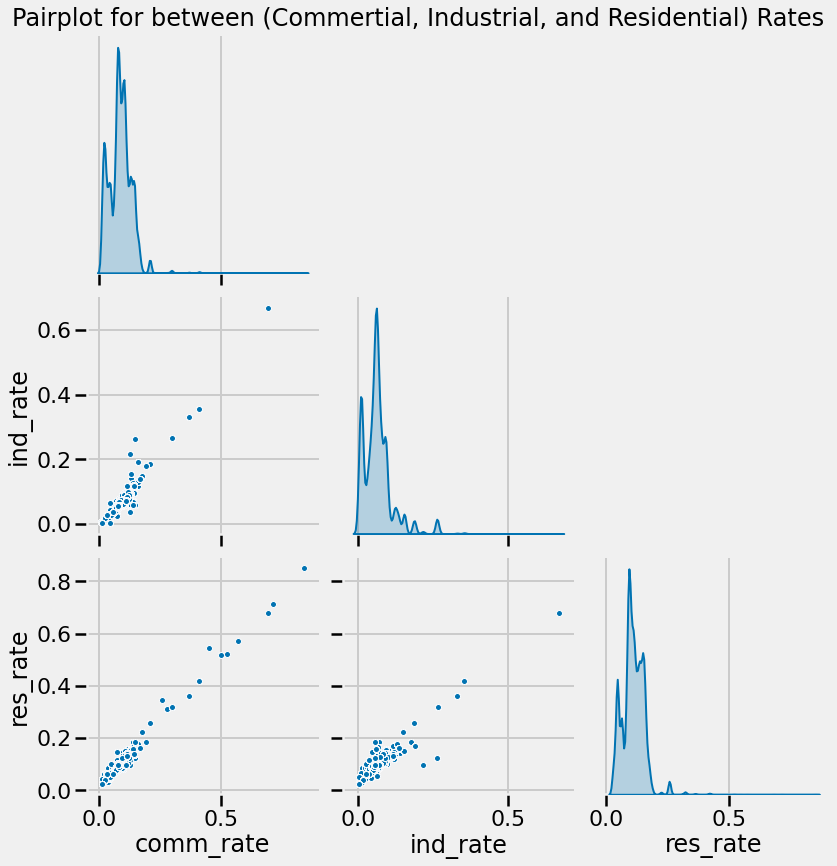

In [18]:
# Choose rate columns
rate_cols = ['comm_rate', 'ind_rate', 'res_rate']

# lets see the pairplot of rates
ax = sns.pairplot(data=df[rate_cols], diag_kind='kde', markers='.', height=4, corner=True)

# Add title
ax.fig.suptitle('Pairplot for between (Commertial, Industrial, and Residential) Rates', 
               size='medium', y=1.01)

plt.show()

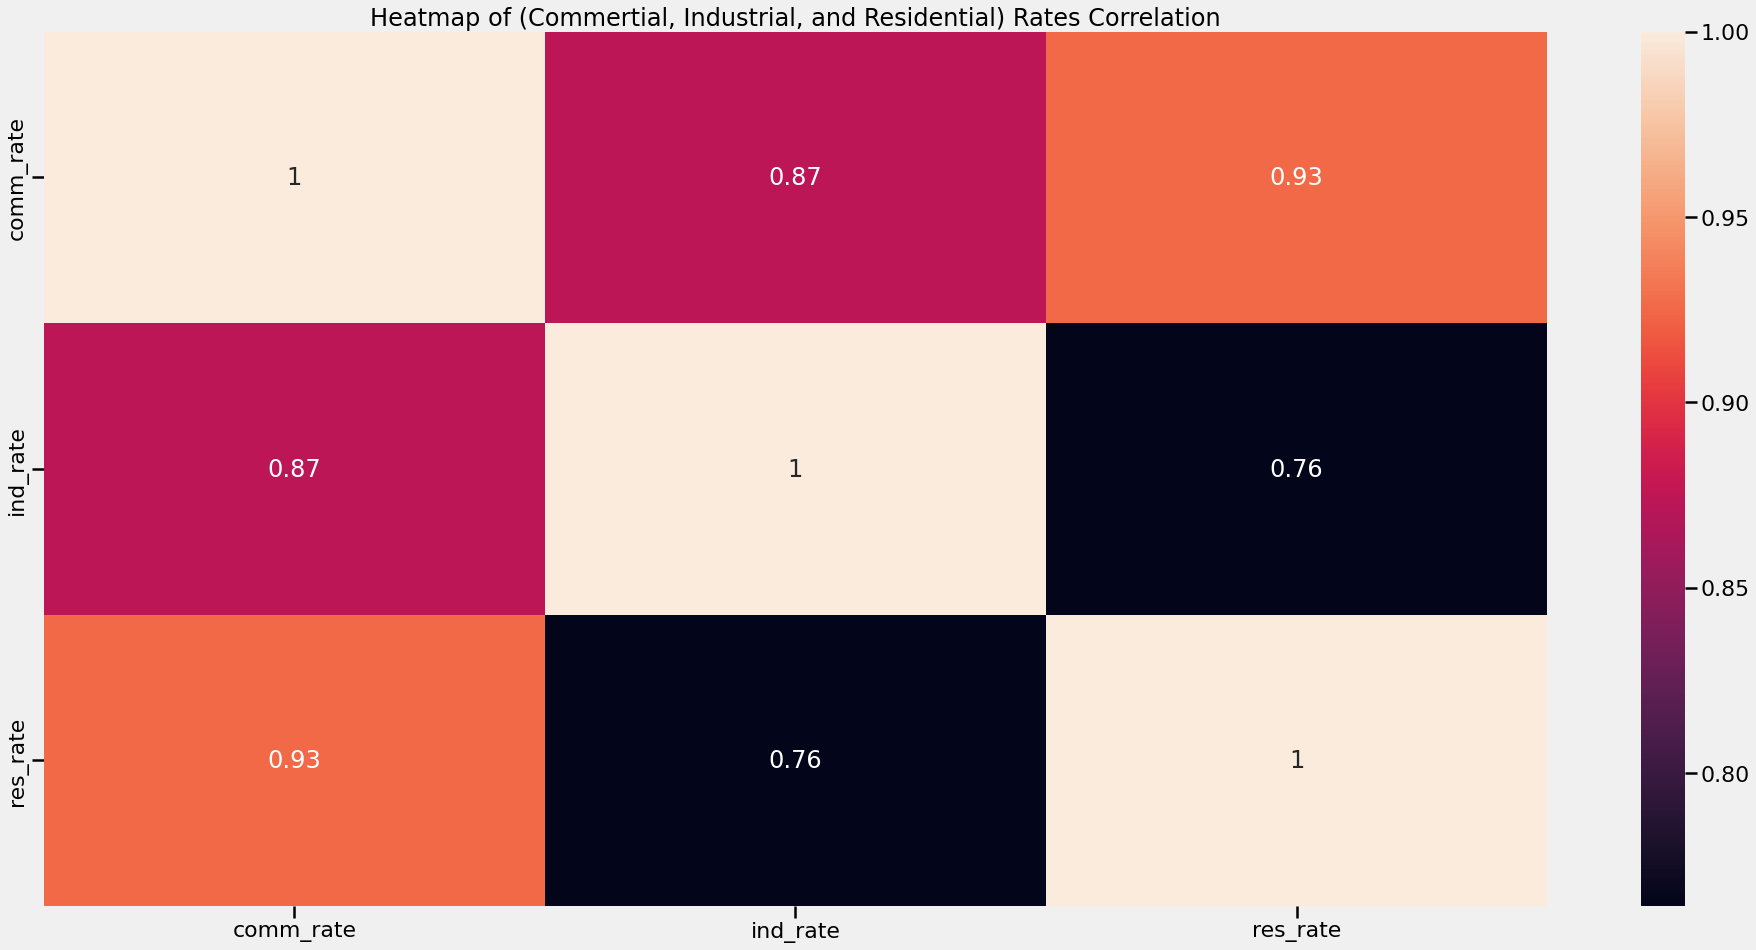

In [19]:
# We will generate heatmap of rates
sns.heatmap(data=df[rate_cols].corr(), annot=True)

# Add title
plt.title('Heatmap of (Commertial, Industrial, and Residential) Rates Correlation')

plt.show()

We can clearly see that there is a strong correlation between different `rate` types in each area, which is very logic.

This positive strong correlation will make us confident about the `overall_score` which we add to each row, let us look more to the scores.

## 03.02 How Scores are Distributed??

After seeing that `rate`s are strongly positive correlated, we need to see if the values lied in the same ranges after making the `score`s, so lets see the box plot for different `score`s

In [20]:
# Choose score columns
score_cols = ['comm_score', 'ind_score', 'res_score', 'overall_score']

# See Summary Stats of scores
df[score_cols].describe()

,comm_score,ind_score,res_score,overall_score
count,37579.000000,36802.000000,36333.000000,37666.000000
mean,1.000000,1.000000,1.000000,0.990845
std,0.526374,0.723083,0.404114,0.532371
min,0.101128,0.024604,0.242652,0.024604
25%,0.660047,0.582735,0.783465,0.684186
50%,0.972284,0.932595,0.993132,0.977905
75%,1.305786,1.241640,1.259043,1.280334
max,9.972902,10.342413,7.930998,8.951950


It seems like the scores has the same distribution, lets see box plots to have more clear idea.

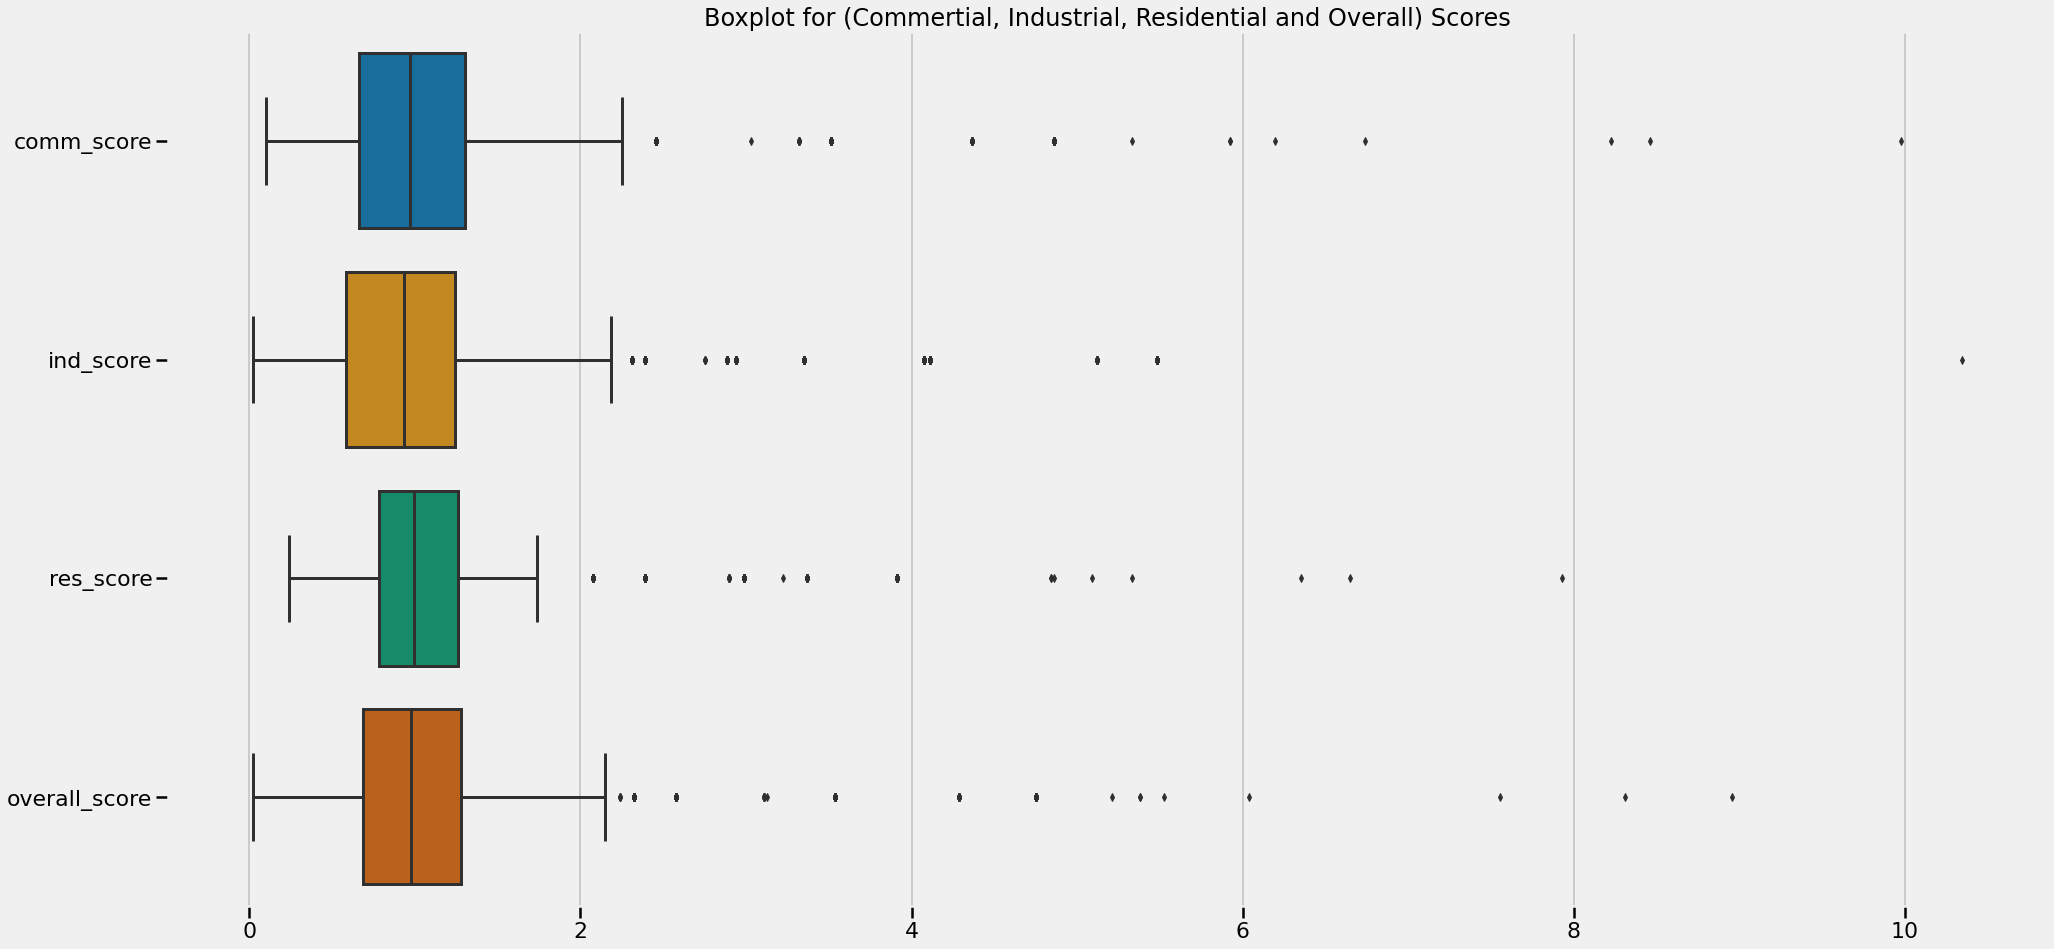

In [21]:
# Drow the boxplot
sns.boxplot(data=df[score_cols], orient='h')

# Add title
plt.title('Boxplot for (Commertial, Industrial, Residential and Overall) Scores')

plt.show()

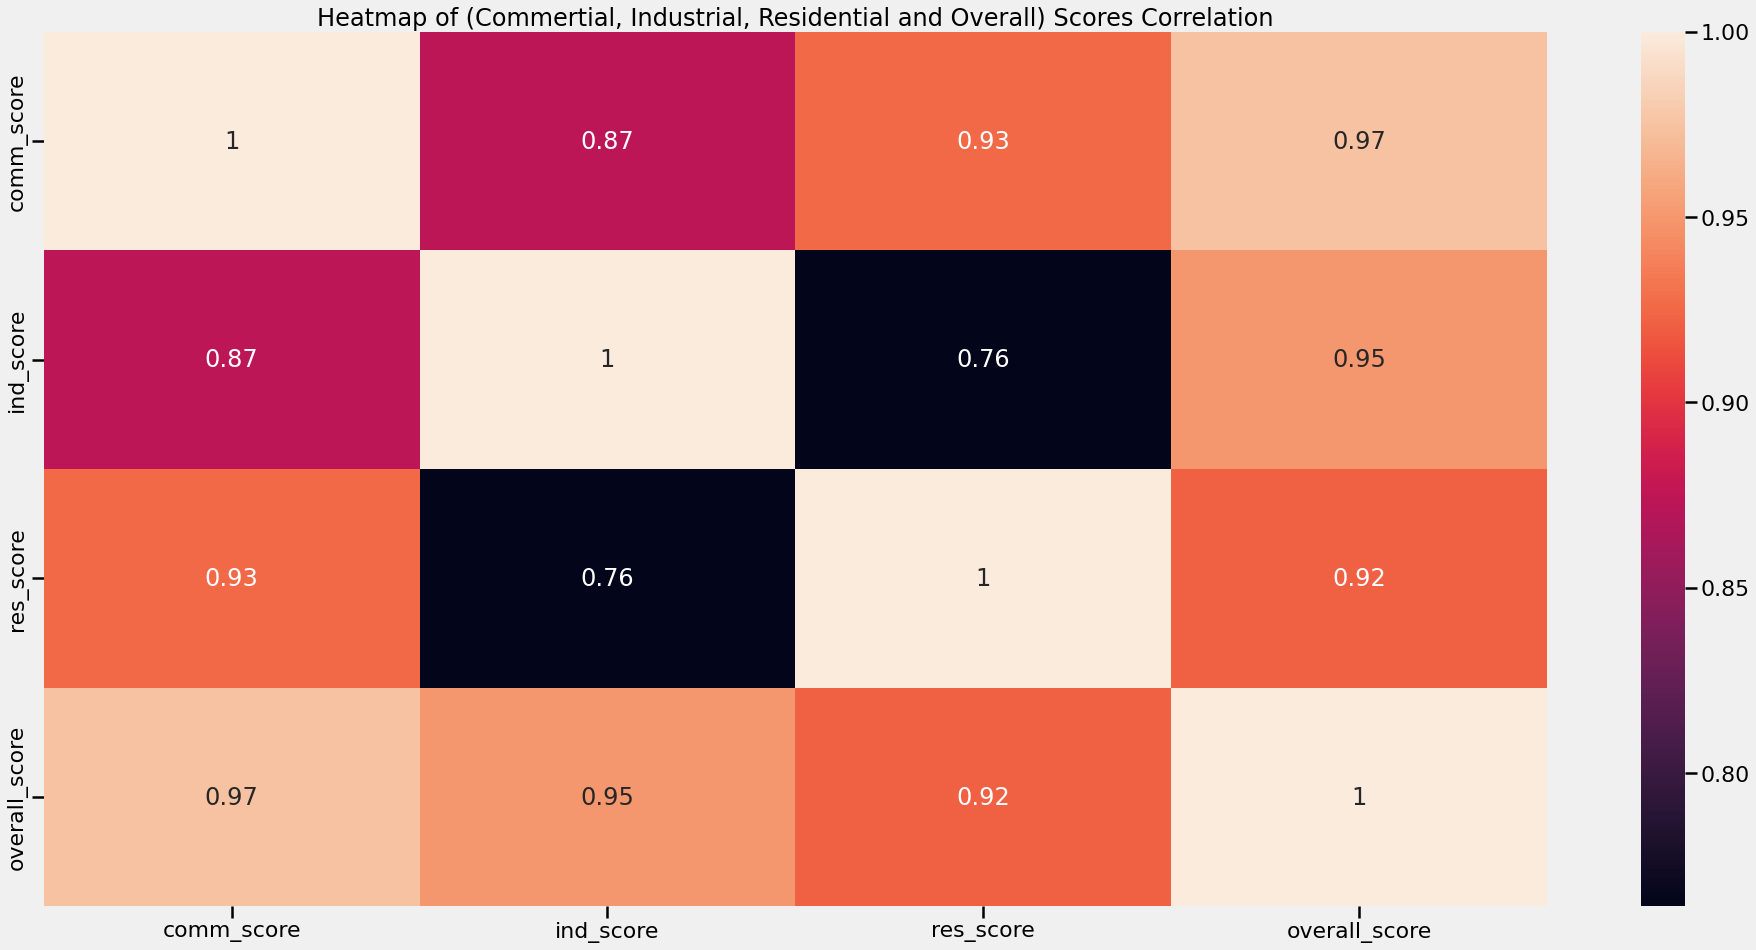

In [22]:
# We will generate heatmap of rate scores
sns.heatmap(data=df[score_cols].corr(), annot=True)

# Add title
plt.title('Heatmap of (Commertial, Industrial, Residential and Overall) Scores Correlation')

plt.show()

We see that scores has almost same distribution and it is highly correlated, we will use this information later, let's see how many outliers we have, to make the calculation easy, we will see the percenatge of values which have `overall_score > 2`.

In [23]:
df_outlier = df[df['overall_score'] > 2]

print('Outlier Percentage = {:.3f}%'.format(len(df_outlier) * 100 / len(df)))

Outlier Percentage = 3.366%


We have less than `3.5%` of outliers, lets see which `state`s has this outliers.

In [24]:
df_outlier.groupby('state')[['overall_score']].agg(['count', 'min', 'mean', 'max'])

overall_score                              
              count       min      mean       max
state                                            
AK               17  3.107543  4.552085  8.951950
CT               62  2.147515  2.147515  2.147515
HI              119  3.539515  3.978248  4.751356
MA                5  2.239647  2.239647  2.239647
NH              176  2.138892  2.138892  2.138892
NY              372  2.576957  2.578440  3.128534
PA              516  2.321339  2.321339  2.321339
RI                1  6.035957  6.035957  6.035957

Last step is that no need for the three `score`s as the `overall_score` represents it all and highly correlated with it, so we will drop them.

In [25]:
df.drop(['comm_score', 'ind_score', 'res_score'], axis=1, inplace=True)

## 03.03 What about Service Type?

We saw before that we have three types of service: `Bundled`, `Delivery`, and `Energy`, lets see:
1. Percentage of each `service` from overall data. 
2. Minumum and Maximum `overall_score` for every `service`.

In [26]:
df_service = df.groupby('service_type')[['overall_score']].agg(['count', 'min', 'max'])

df_service['percentage_from_total_data'] = df_service[('overall_score','count')
                                                    ] * 100 / df_service[('overall_score','count')].sum()

df_service

overall_score                     percentage_from_total_data
                     count       min       max                           
service_type                                                             
Bundled              25101  0.699312  8.951950                  66.641002
Delivery             12532  0.024604  1.182472                  33.271385
Energy                  33  0.871784  0.871784                   0.087612

We can see that:
1. Most of `service`s are `Bundled` which has aroung `2/3` of data then `Delivery` which has around `1/3` of data.
2. Only we have `33` number of `Energy` service, less that `1%`.
3. We can be sure that the `rate`s with `overall_score` less than `0.69` are `Delivery`, while the `rate`s with `overall_score` above `1.2` are `Bundled`.

## 03.04 Energy Service Type Analysis

`Energy` service has a few records, let us see where it locates and the values which it has.

In [27]:
df[df['service_type'] == 'Energy'].groupby(['state', 'utility_name','county_name']
                                          )[rate_cols].agg(['count', 'mean', 'std'])

comm_rate                ind_rate  \
                                            count      mean  std    count   
state utility_name          county_name                                     
IL    MidAmerican Energy Co Henry               7  0.069222  0.0        7   
                            Mercer              5  0.069222  0.0        5   
                            Rock Island        21  0.069222  0.0       21   

                                                       res_rate           
                                             mean  std    count mean std  
state utility_name          county_name                                   
IL    MidAmerican Energy Co Henry        0.059576  0.0        0  NaN NaN  
                            Mercer       0.059576  0.0        0  NaN NaN  
                            Rock Island  0.059576  0.0        0  NaN NaN

We can observe that `Energy` service:
1. Locates only in `IL` state.
2. Provided only from `MidAmerican Energy Co`.
3. Has fixed values (because `std = 0`) of both `comm` and `ind` rates.
4. Doesn't jave `res_rate`.

## 03.05 Visualization of Overall Score per State

We need here to see the `state`s ordered by `median` `overall_score` to see which `state`s are cheapest and which are the most expensive, we will visualize by boxplot per state.

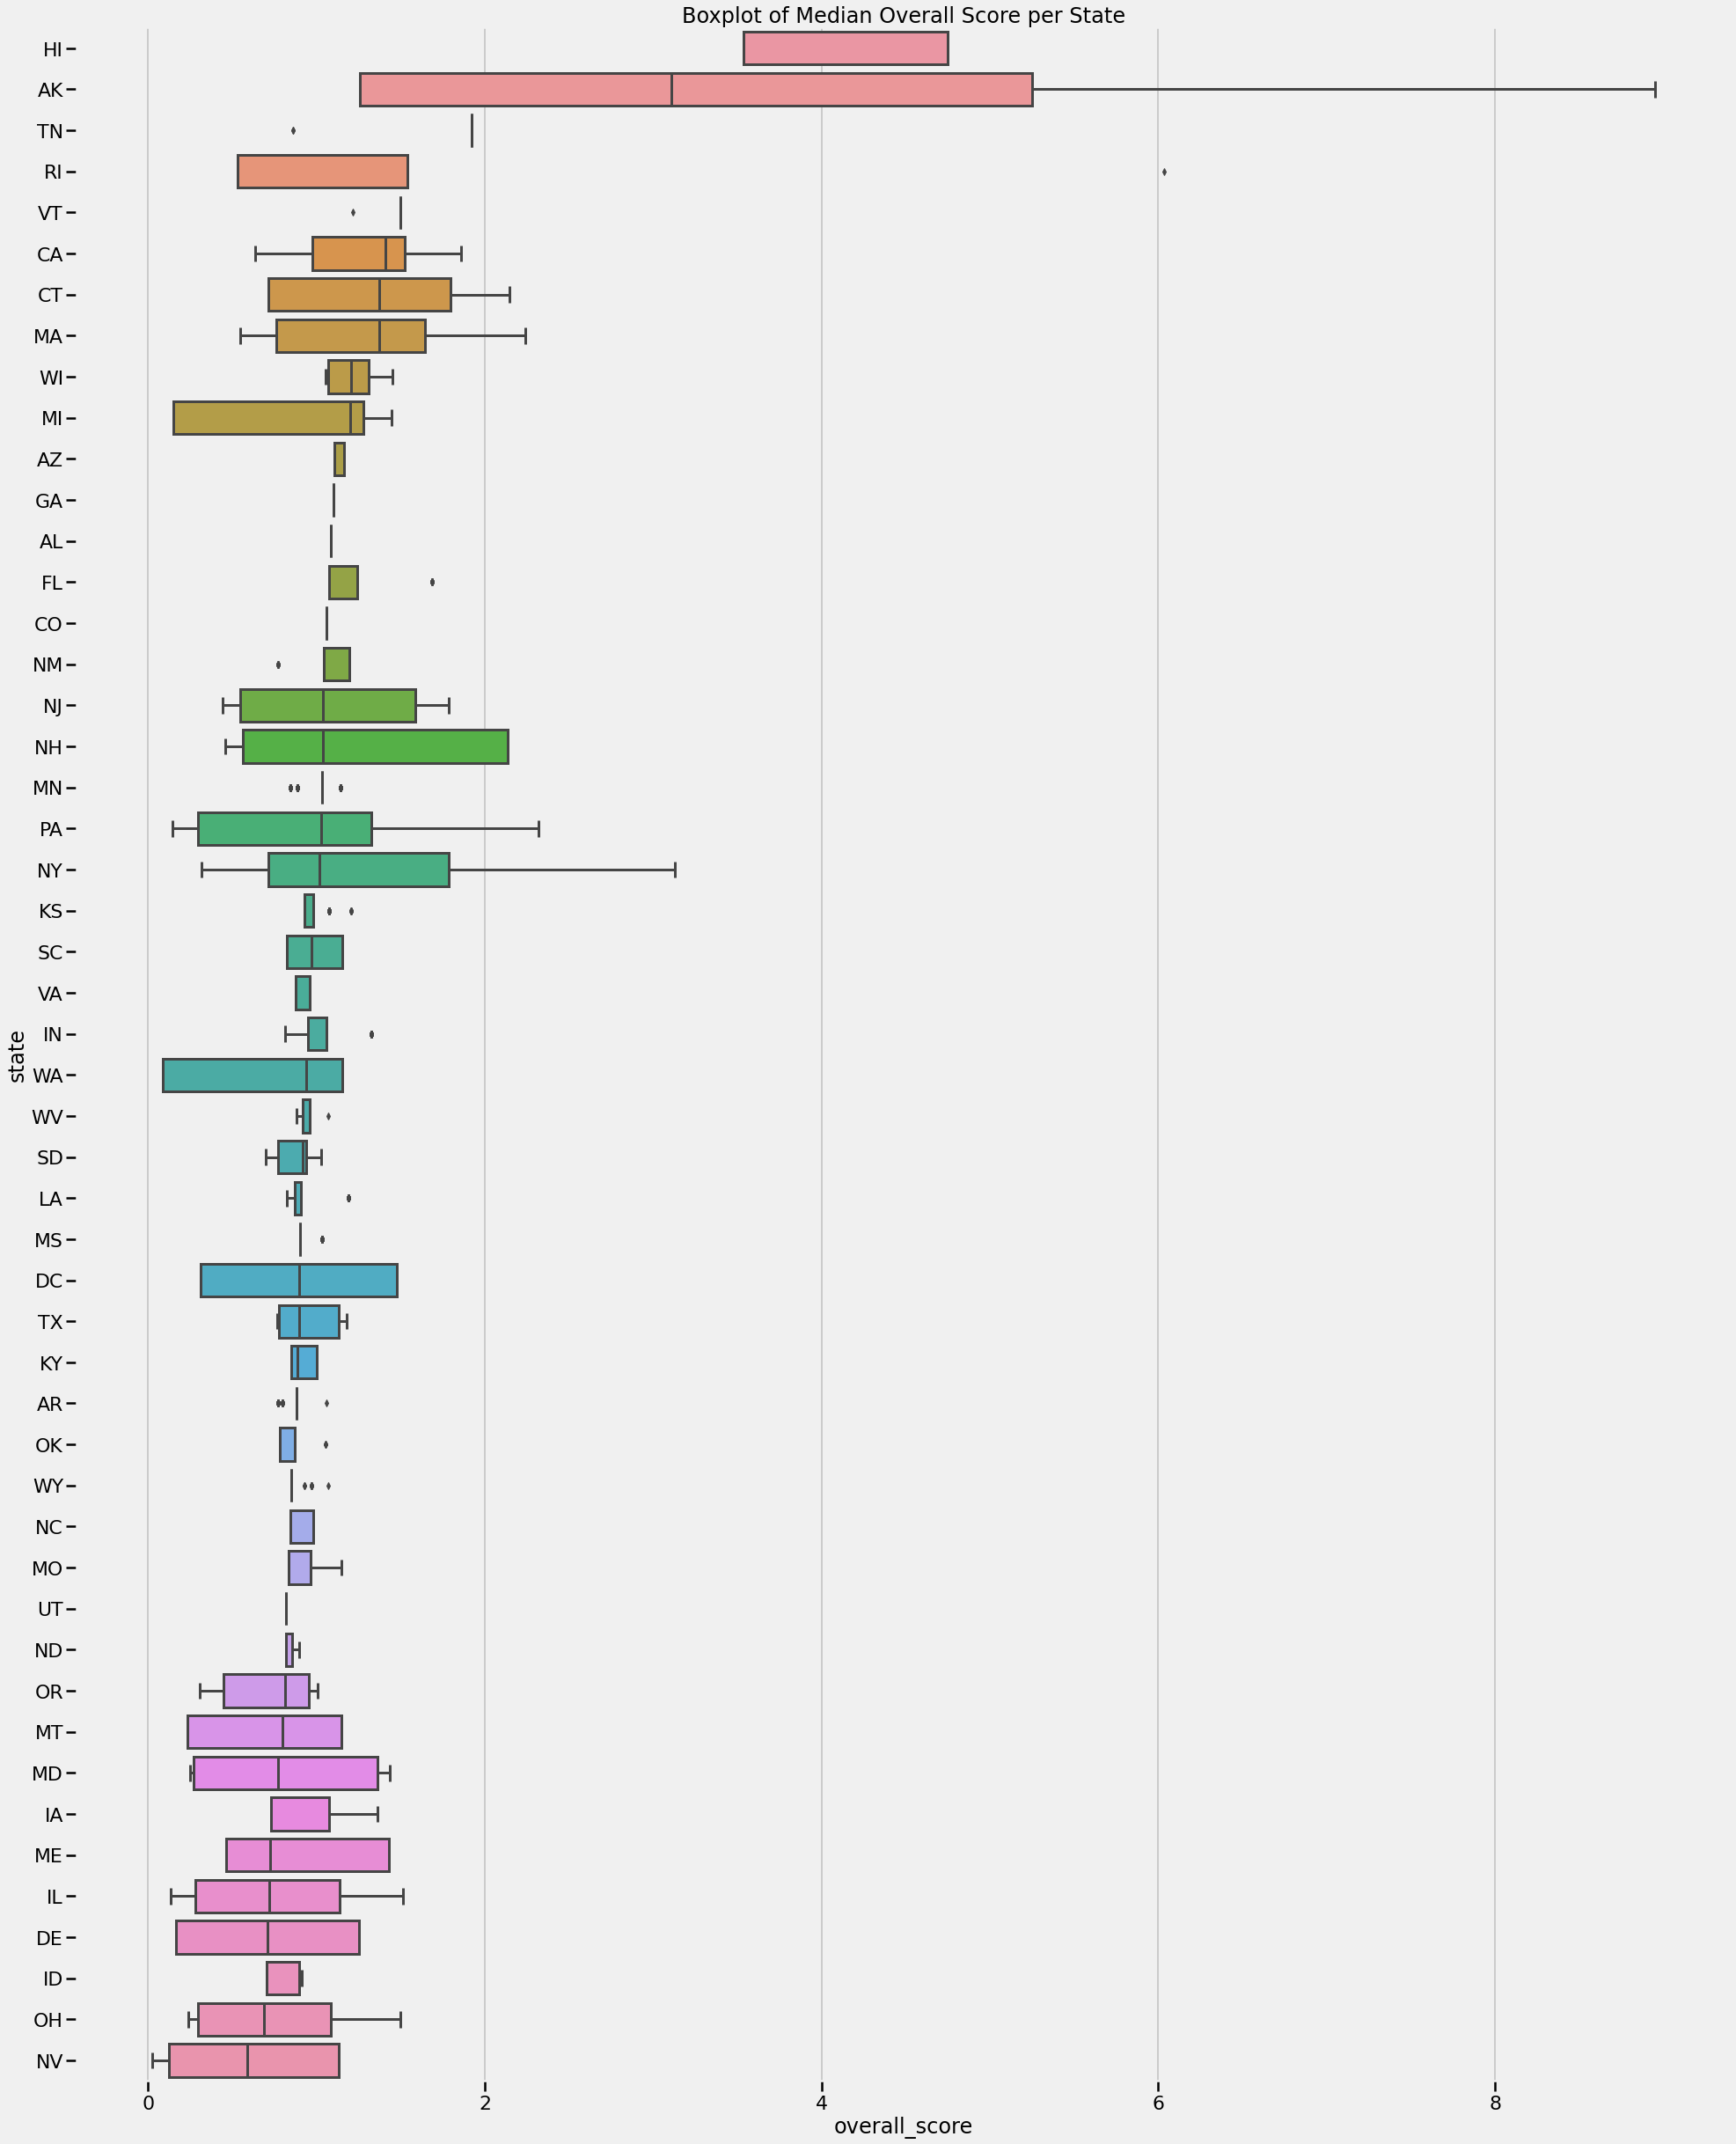

In [28]:
# Group by state then sort descending by overall_score median, we will take the states order to make the plot 
state_order = df.groupby('state')[['overall_score']].median().sort_values('overall_score', 
                                                                          ascending=False).index.values

# Set plot size
plt.figure(figsize=(30, 40))

# Make the boxplot
sns.boxplot(data=df, x='overall_score', y='state', order=state_order)

# Add title
plt.title('Boxplot of Median Overall Score per State')

plt.show()

## 03.06 Visualization of Overall Score per Utility Company

We need here to see the `utility_name`s ordered by median `overall_score` to see which Utilities are cheapest and which are the most expensive, we will visualize by boxplot per `utility_name`.

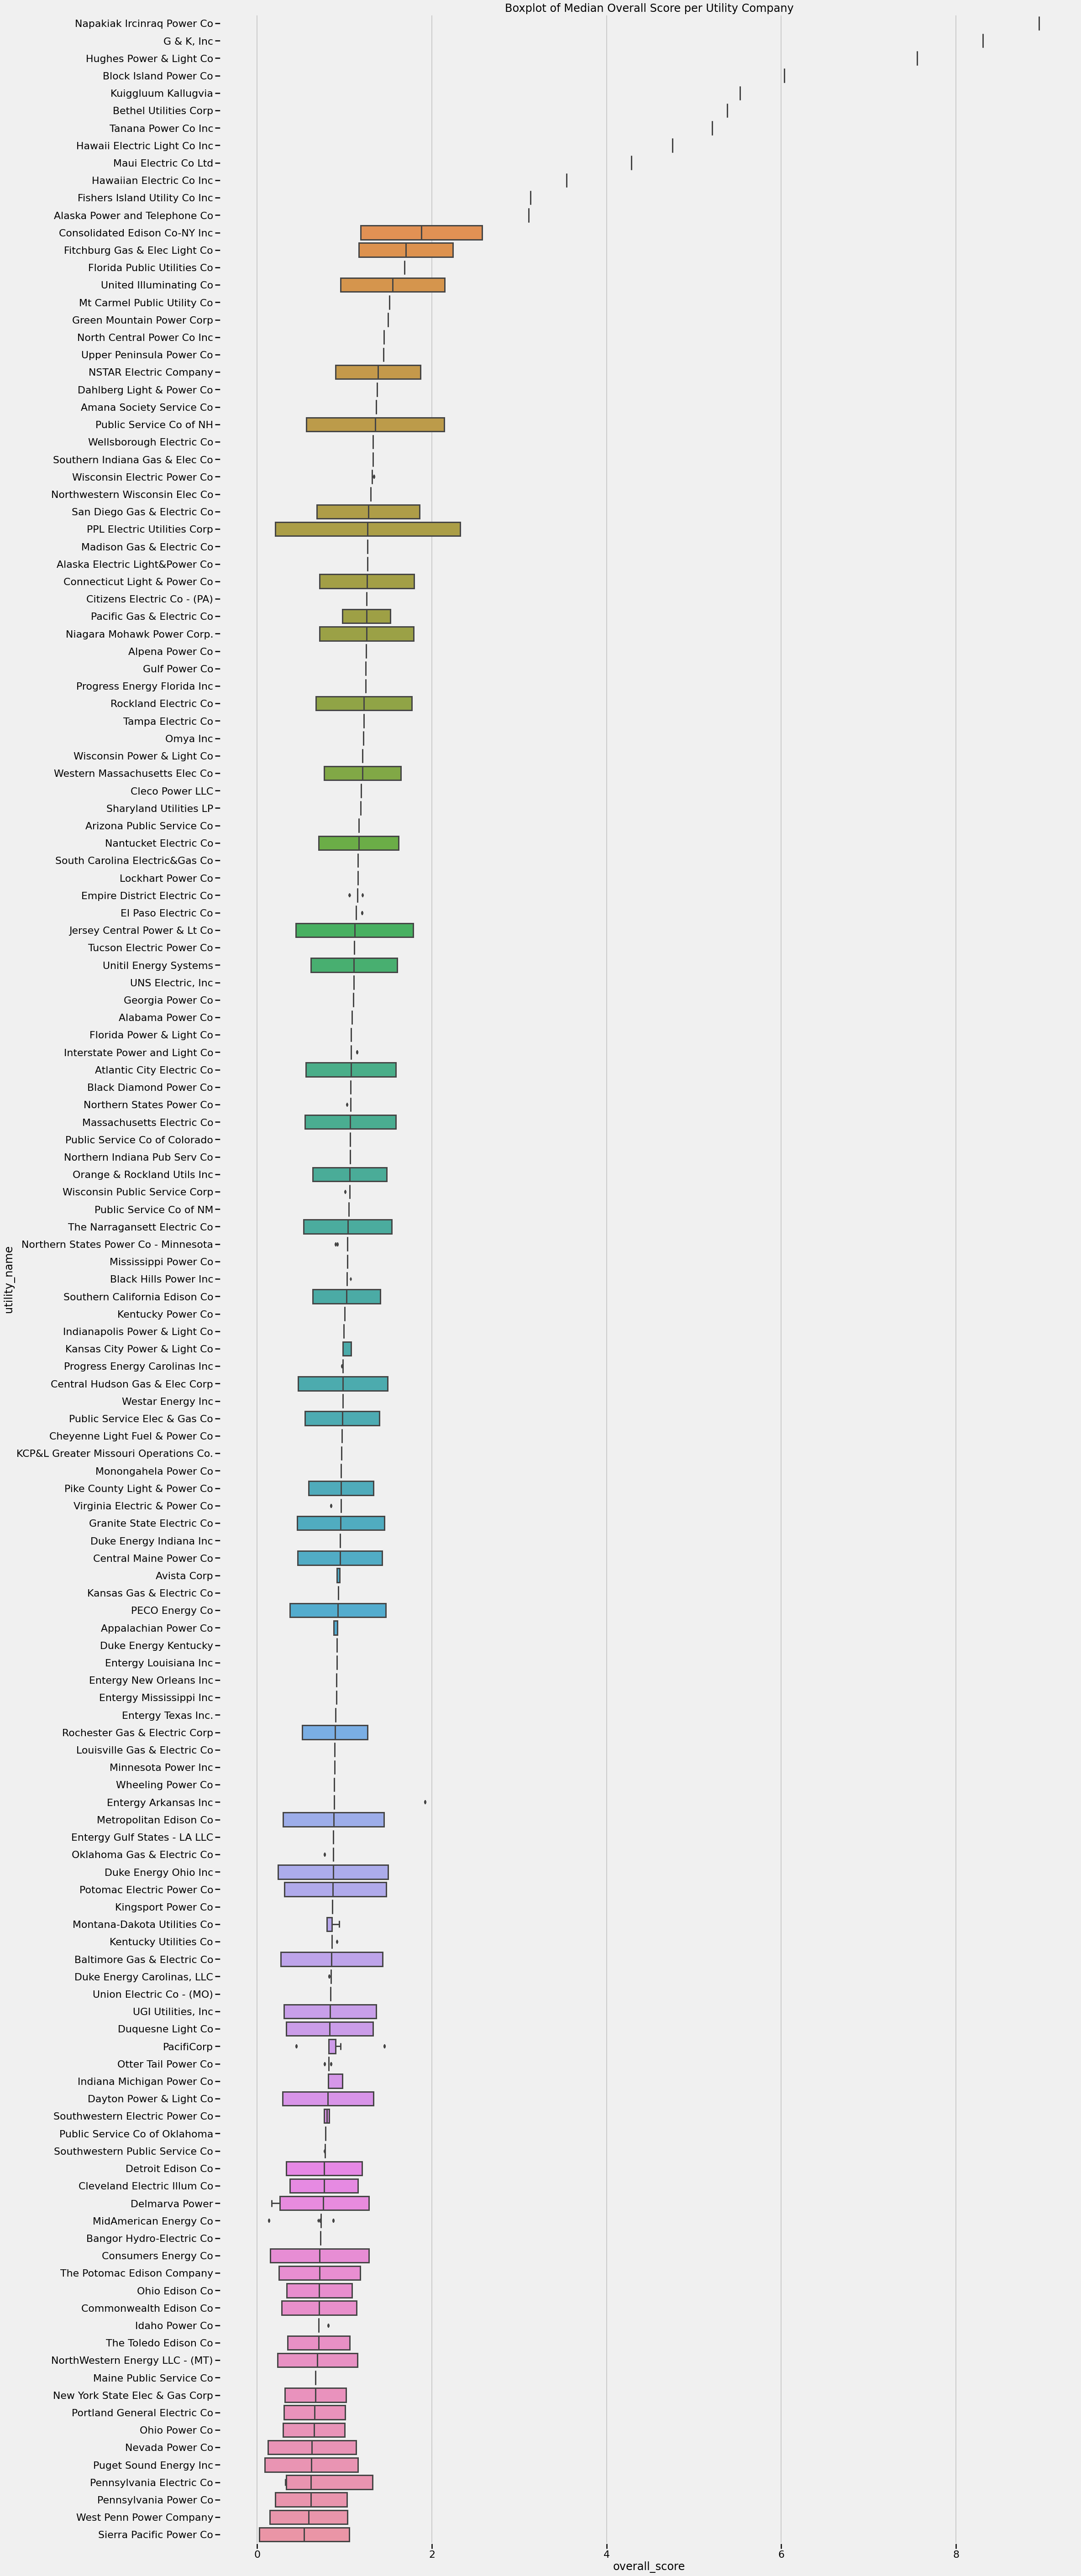

In [29]:
# Group by utility then sort descending by overall_score median, we will take the utlility order to make the plot
utility_order = df.groupby('utility_name')[['overall_score']].median().sort_values('overall_score',
                                                                                   ascending=False).index.values

# Set plot size
plt.figure(figsize=(30, 95))

# Make the boxplot
sns.boxplot(data=df, x='overall_score', y='utility_name', order=utility_order)

# Add title
plt.title('Boxplot of Median Overall Score per Utility Company')

plt.show()

# 04 Electricity Rates Clustering

Until now we cleaned our data and analyze all features, the next step is to cluster our data but how?

We need to cluster the data based on the `rate`s only, we don't need for any other variable like location, service, utility ..., to effect our clustering.

So, as we have to enter the three types of `rate`s to our model, **but here there is a problem**, the problem is that some rates has `NaN` values where the `rate` is not applicable, and we can't replace this values with `0` because this will effect the correlation between the `rate`s so the model will be effected.

Another solution is by using `overall_score` because it has a value which represents the three `rate`s (with high correlation as seen before) and also it excludes the `NaN` values.

We will apply `Kmeans` Clustering to `overall_score` as feature.

## 04.01 Choosing the Optimal Number of Clusters using Elbow Method

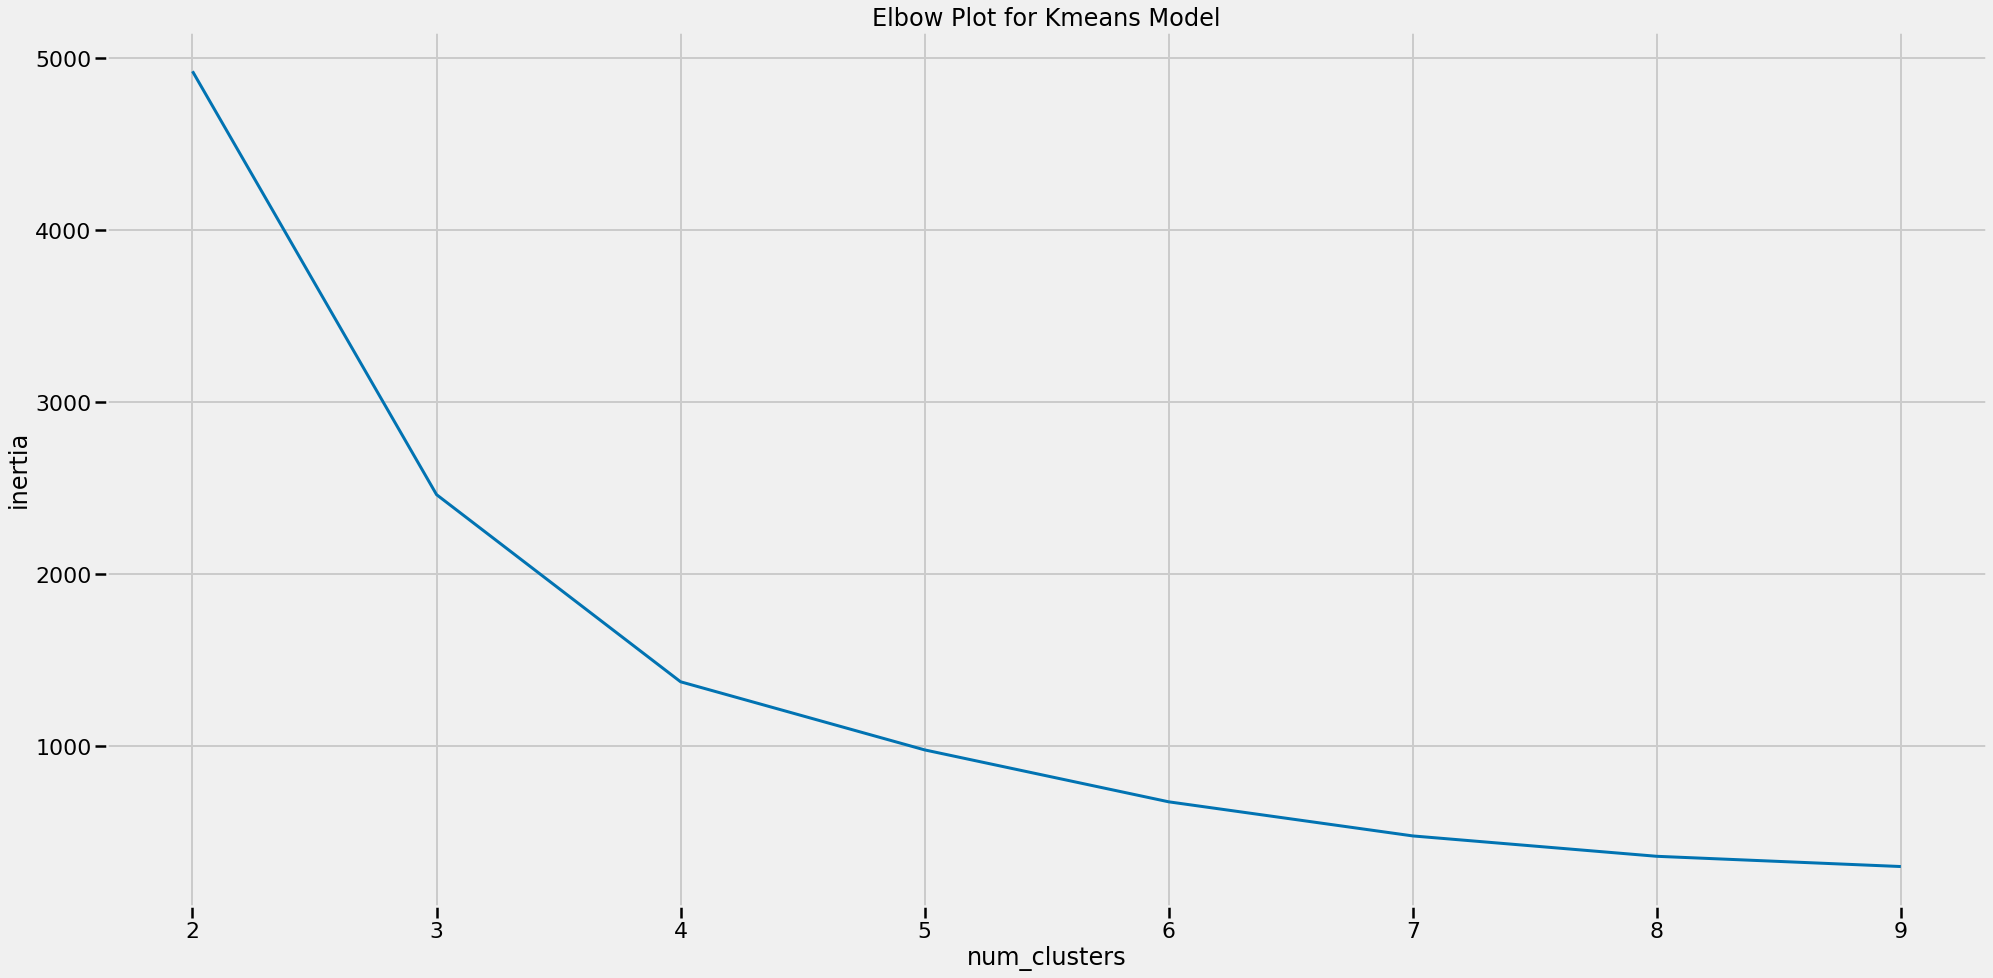

In [30]:
inertia = []

# Prepare overall_score as numpy array
X = df[['overall_score']].to_numpy()

# Iterate from 2 to 9 clusters and collect inertias
for i in range(2,10):
    km = KMeans(n_clusters=i, init='k-means++', n_init=25)
    km.fit(X)
    inertia.append(km.inertia_)
    
# convert no_clusters and inertia to datafram    
elbow_plot_data = pd.DataFrame({'num_clusters': range(2,10), 
                                'inertia': inertia})

# Make lineplot
sns.lineplot(x='num_clusters', y='inertia', data = elbow_plot_data)

# Add title
plt.title('Elbow Plot for Kmeans Model')

plt.show()    

From the Elbow plot, we can find the `4` clusters is the optimal number of clusters.

## 04.02 Building Model and Label Clusters to our Dataset

In [31]:
# Build kmeans with 4 clusters
km = KMeans(n_clusters=4, init='k-means++', n_init=25)
# Fit model
km.fit(X)

# Add model label to df (we will add 1 so cluster numbering will start from 1)
df['cluster_label'] = km.labels_ + 1
df.head()

,utility_name,service_type,state,county_name,latitude,longitude,comm_rate,ind_rate,res_rate,overall_score,cluster_label
0,Alabama Power Co,Bundled,AL,Jefferson,33.5060,-86.8930,0.105761,0.060292,0.114943,1.087075,1
1,Alabama Power Co,Bundled,AL,Jefferson,33.5446,-86.9292,0.105761,0.060292,0.114943,1.087075,1
2,Alabama Power Co,Bundled,AL,Jefferson,33.5554,-86.8870,0.105761,0.060292,0.114943,1.087075,1
3,Alabama Power Co,Bundled,AL,Jefferson,33.6493,-86.7057,0.105761,0.060292,0.114943,1.087075,1
4,Alabama Power Co,Bundled,AL,Jefferson,33.4188,-86.7867,0.105761,0.060292,0.114943,1.087075,1


We need to give represented names to our cluster groups, so we will decide the names based on each cluster range.

In [32]:
# groupb label and see overall score ranges, we will descending order based on maximum overall_score
df_cluster_order = df.groupby('cluster_label')[['overall_score']].agg(
['min', 'mean', 'max']).sort_values(('overall_score', 'max')).reset_index()

df_cluster_order

cluster_label overall_score                    
                          min      mean       max
0             2      0.024604  0.343495  0.637348
1             1      0.669990  0.965880  1.218727
2             4      1.241467  1.498809  1.922869
3             3      2.138892  2.550956  8.951950

Based on values, we will call clusters: (Low, Average, High and Very High), to do it and keep the sorting as mentioned, we will add column `cluster_rate` as `categorial` data type, (Note: we will follow same ordering of `cluster_label` as it is sorted ascendingly).

In [33]:
# define rate order list 
rate_order = ['Low Rates', 'Average Rates', 'High Rates', 'Very High Rates']

# Make dictionary cluster order to use it directly in replace function
cluster_order = dict(zip(df_cluster_order['cluster_label'], rate_order))
cluster_order

{2: 'Low Rates', 1: 'Average Rates', 4: 'High Rates', 3: 'Very High Rates'}

In [34]:
# Define rate order as ordered categorical type 
cat_type = CategoricalDtype(categories=rate_order, ordered=True)

# Add cluster_rate column using replace with (cluster_order) and define it as (cat_type) 
df['cluster_rate'] = df['cluster_label'].replace(cluster_order).astype(cat_type)

# Sort values by cluster_order
df.sort_values('cluster_rate', inplace=True, ignore_index=True)

df.head()

,utility_name,service_type,state,county_name,latitude,longitude,comm_rate,ind_rate,res_rate,overall_score,cluster_label,cluster_rate
0,Detroit Edison Co,Delivery,MI,Shiawassee,42.8200,-84.2313,0.022641,0.011946,0.058960,0.334621,2,Low Rates
1,Potomac Electric Power Co,Delivery,DC,District of Columbia,38.8933,-77.0146,0.036212,0.013371,0.032192,0.312424,2,Low Rates
2,Potomac Electric Power Co,Delivery,DC,District of Columbia,38.8933,-77.0146,0.036212,0.013371,0.032192,0.312424,2,Low Rates
3,Potomac Electric Power Co,Delivery,DC,District of Columbia,38.8933,-77.0146,0.036212,0.013371,0.032192,0.312424,2,Low Rates
4,Potomac Electric Power Co,Delivery,DC,District of Columbia,38.8933,-77.0146,0.036212,0.013371,0.032192,0.312424,2,Low Rates


## 04.03 Visualize Clusters with Rates

Lets see the pairplot of clusters with different `rate`s.

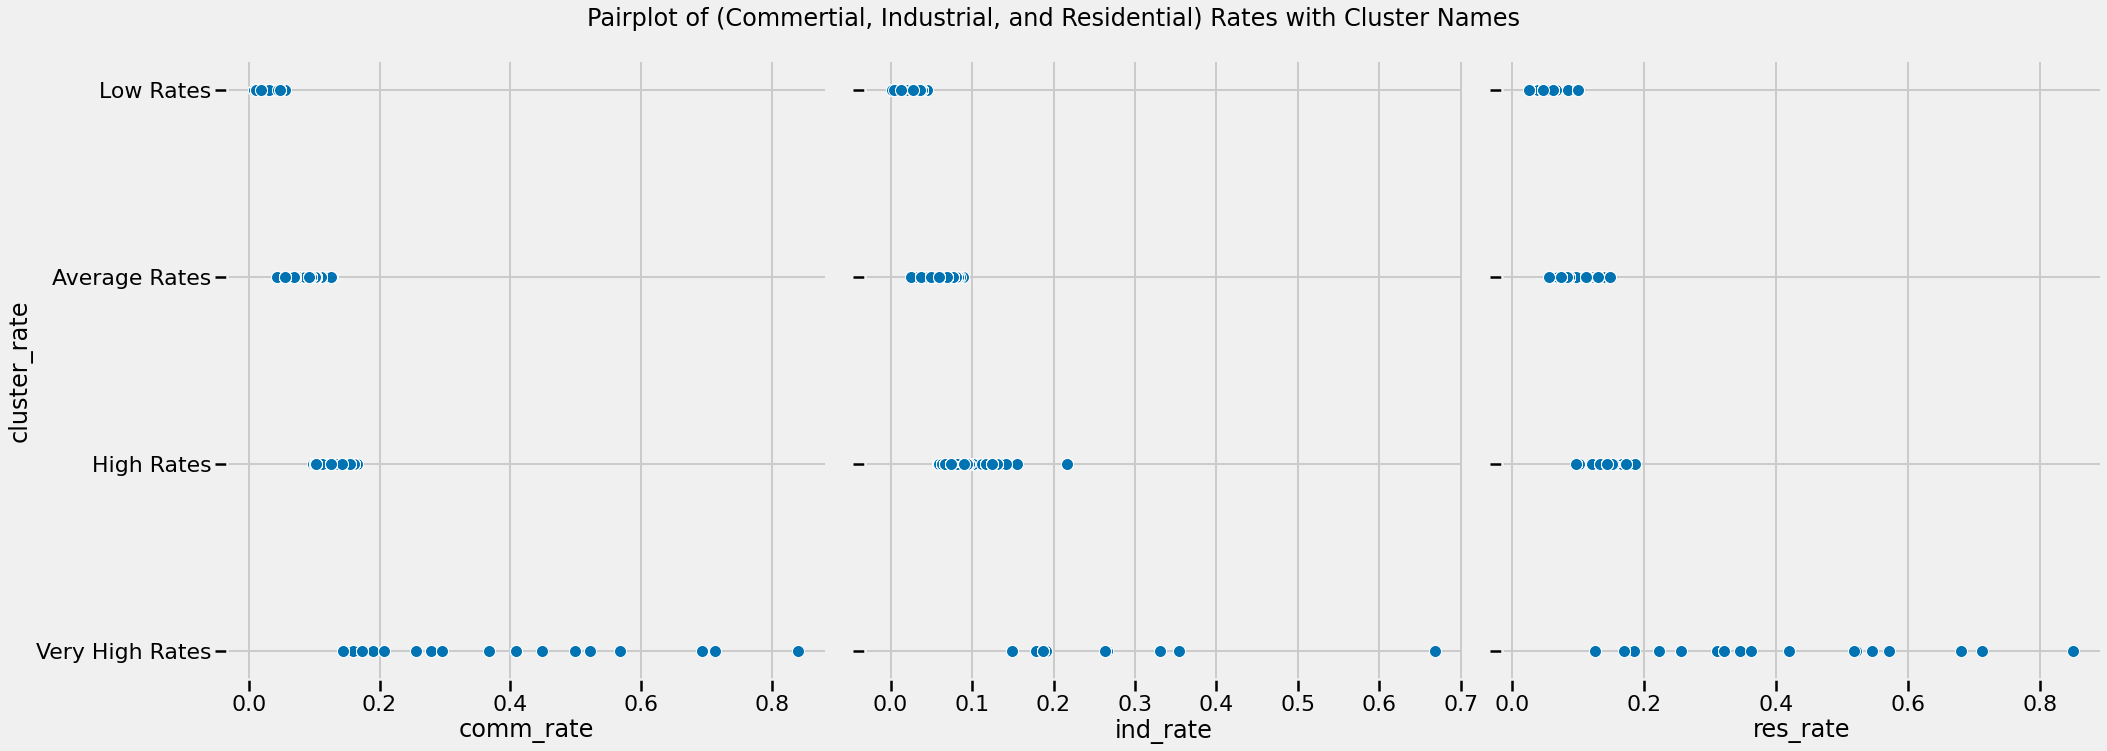

In [35]:
# Pairplot with rates as row and cluster_rate as common y-axis
ax = sns.pairplot(data=df, x_vars=['comm_rate', 'ind_rate', 'res_rate'], y_vars='cluster_rate', height=10)

# Add title
ax.fig.suptitle('Pairplot of (Commertial, Industrial, and Residential) Rates with Cluster Names',
         size='medium', y=1.05)

plt.show()

We can see that `rate`s are mostly good clustered, recall that clustering done with `overall_score` only.

Now lets see the percentage of each cluster from the whole dataset.

In [36]:
# Groupby cluster_rate and count the rows
df_count = df.groupby(['cluster_rate'])[['overall_score']].count()

# Calculate %
df_count['percentage_from_total_data'] = df_count['overall_score'] * 100 / df_count['overall_score'].sum()
df_count

,overall_score,percentage_from_total_data
cluster_rate,,
Low Rates,9329,24.767695
Average Rates,18181,48.268996
High Rates,8888,23.596878
Very High Rates,1268,3.366431


It looks like normally distributed, aroung half of `rate`s are `Average`, while around `3.4%` are `Very High` (approximately same percentage of outliers calculated before).

# 05 Geo-Visualization of Clusters

## 05.01 Data Reduction before Geo-Visualization

**Why??** Because we have a very large data which will have overlapping and kill the memory.

**How??** We should think in the way to reduce data, and at the same time not lose any information that we need to visualize.

**Solution:** We will group by (`utility_name`, `service_type`, `state`, `county_name`, and `cluster_label` (we will use it as `size` of points in the plot), by doing this we are grouping all data which has equal features so we can represent all of it by one center point (this center point will be defined as the `median` of all `latitude`, `longitude`, `rate`s and `overall_score`).

Note: we will after add a column `cluster_rate`, because when I put it in the groupby, jupyter raise a memory error then crashes (may be because its categorical type).

In [37]:
# take `utility_name`, `service_type`, `state`, `county_name`, and `cluster_label` columns
groupby_cols = [*df.columns[:4]] + ['cluster_label']

# define df_map as explained above and reset index
df_map = df.groupby(groupby_cols)[df.columns[4:10]].agg({
    'latitude': 'median', 'longitude': 'median', 'comm_rate':['median', 'std'], 
    'ind_rate': ['median', 'std'], 'res_rate': ['median', 'std'], 
    'overall_score': ['median', 'std']}).reset_index()

# Fill NaN with '' (importent for hover data format)
df_map.fillna('', inplace=True)

# Add cluster_rate (same before)
df_map['cluster_rate'] = df_map['cluster_label'].replace(cluster_order).astype(cat_type)

print('Percentage of data in df_map compared to original = {:.3f}%, '.format(
    len(df_map) * 100 / len(df)), 'and number of rows = ', len(df_map), '\n')

# Check that we don't miss any importent information by seeing number of unique values in string columns in df_map 
# and compare it with the number of unique values in string columns in df 
df_map.describe(exclude='number')

Percentage of data in df_map compared to original = 8.732%,  and number of rows =  3289 



utility_name service_type state county_name    comm_rate          \
                                                              median     std   
count               3289         3289  3289        3289  3289.000000  3289.0   
unique               145            3    50        1387   243.000000     2.0   
top     Georgia Power Co      Bundled    PA  Washington     0.098764     0.0   
freq                 123         2568   228          34   123.000000  2780.0   

           ind_rate         res_rate         overall_score   cluster_rate  
             median     std   median     std           std                 
count   3289.000000  3289.0     3289  3289.0        3289.0           3289  
unique   227.000000     2.0      235     2.0           2.0              4  
top        0.065769     0.0              0.0           0.0  Average Rates  
freq     123.000000  2749.0      123  2677.0        2791.0           2139

Nothing from unique values are missed, also the `std` of all `rate`s and `overall_Score` is `0` which means that each point is representative of its group.

It will be great to have a representative geo-visualization of dataset with less than 9% of data, this will make the map looking better and save the memory.

In [38]:
# Lets see first rows, we have to drop `std` columns and rename the columns
df_map.head()

utility_name service_type state county_name cluster_label latitude  \
                                                                   median   
0  Alabama Power Co      Bundled    AL     Autauga             1  32.4751   
1  Alabama Power Co      Bundled    AL     Barbour             1  31.8982   
2  Alabama Power Co      Bundled    AL        Bibb             1  33.0427   
3  Alabama Power Co      Bundled    AL      Blount             1  33.9259   
4  Alabama Power Co      Bundled    AL     Bullock             1  32.1199   

  longitude comm_rate       ind_rate       res_rate      overall_score       \
     median    median  std    median  std    median  std        median  std   
0 -86.47140  0.105761  0.0  0.060292  0.0  0.114943  0.0      1.087075  0.0   
1 -85.15555  0.105761  0.0  0.060292  0.0  0.114943  0.0      1.087075  0.0   
2 -87.12640  0.105761  0.0  0.060292  0.0  0.114943  0.0      1.087075  0.0   
3 -86.56860  0.105761  0.0  0.060292  0.0  0.114943  0.0      1.087075  0.0   
4 -85.62320  0.105761  0.0  0.060292  0.0  0.114943  0.0      1.087075  0.0   

    cluster_rate  
                  
0  Average Rates  
1  Average Rates  
2  Average Rates  
3  Average Rates  
4  Average Rates

In [39]:
# drop std_columns
df_map.drop(df_map.columns[[8, 10, 12, 14]], axis=1, inplace=True)

# Remove (median) from column names
df_map.columns = [col[0] for col in df_map.columns]

# Put cluster_label column before cluster_rate
cols = [*df_map.columns[:4]] + [*df_map.columns[5:11]] + [df_map.columns[4]] + [df_map.columns[-1]]
df_map = df_map[cols]

df_map.head()

,utility_name,service_type,state,county_name,latitude,longitude,comm_rate,ind_rate,res_rate,overall_score,cluster_label,cluster_rate
0,Alabama Power Co,Bundled,AL,Autauga,32.4751,-86.47140,0.105761,0.060292,0.114943,1.087075,1,Average Rates
1,Alabama Power Co,Bundled,AL,Barbour,31.8982,-85.15555,0.105761,0.060292,0.114943,1.087075,1,Average Rates
2,Alabama Power Co,Bundled,AL,Bibb,33.0427,-87.12640,0.105761,0.060292,0.114943,1.087075,1,Average Rates
3,Alabama Power Co,Bundled,AL,Blount,33.9259,-86.56860,0.105761,0.060292,0.114943,1.087075,1,Average Rates
4,Alabama Power Co,Bundled,AL,Bullock,32.1199,-85.62320,0.105761,0.060292,0.114943,1.087075,1,Average Rates


## 05.02 Geo-Visualization

In [40]:
fig = px.scatter_geo(data_frame = df_map, lat='latitude', lon='longitude', opacity=0.5, scope='usa',
                     color='cluster_rate', size='cluster_label', symbol='service_type', size_max=5,
                     hover_name='utility_name', title='US Electricity Utility Rates Goe-Visualization', 
                     hover_data={
                         'latitude': False, 'longitude': False, 'cluster_rate': False,'service_type': False, 
                         'cluster_label': False, 'state': True, 'county_name': True, 'comm_rate': ':.3f', 
                         'ind_rate': ':.3f', 'res_rate': ':.3f', 'overall_score': ':.3f'
                     })

fig.show()

# 06 Clustering with Features Summary Dataset 

We can see in the map that some areas have unique clustering, but others are mixed, here we will try to find why, we need to make one summary dataframe with below steps:
- We will take all `state`s which has a unique `cluster_rate`.
- For `state`s which has mixed `cluster_rate`s, we will take all `county_name`s which has a unique `cluster_rate`. 
- For `county_name`s which has mixed `cluster_rate`s, we will take all `service_type`s which has a unique `cluster_rate`.
- For `service_types`s which has mixed `cluster_rate`s, we will take all `utility_name`s which has a unique `cluster_rate`.
- We will combine all 4 dataframes together (we will replace NaN values with **'All'**).

We will do all steps as follow:
1. Groupby the feature we are looking for, and take the `mean` and `std` of `cluster_label`.
2. Target features are the ons which have unique value (`std = 0` or `std = NaN`), also the `mean` for these values is the same value of `cluster_label`, we will filter and save it.
3. We will take remaining mixed values of the features alone, then inner merge it with the origional dataframe so we will be sure that these values are the one which we will need for the next step.
4. Repeat.

## 06.01 States Analysis

In [41]:
# step 1
df_state = df.groupby('state')['cluster_label'].agg(['mean', 'std']).reset_index()

# step 2
df_unique_state = df_state[df_state['std'] == 0].copy().reset_index(drop=True)

# step 3
df_not_unique_state = df_state[df_state['std'] > 0][['state']]
df_merge_state = df.merge(df_not_unique_state[['state']], on='state')

df_unique_state.head()

,state,mean,std
0,AL,1.0,0.0
1,AR,1.0,0.0
2,AZ,1.0,0.0
3,CO,1.0,0.0
4,GA,1.0,0.0


## 06.02 Counties Analysis

In [42]:
# step 1
df_county = df_merge_state.groupby(['state', 'county_name'])['cluster_label'].agg(['mean', 'std']).reset_index()

# step 2
df_unique_county = df_county[(df_county['std'] == 0) | (df_county['std'].isna())
                            ].copy().reset_index(drop=True)

# step 3
df_not_unique_county = df_county[~((df_county['std'] == 0) | (df_county['std'].isna()))]
df_merge_county = df_merge_state.merge(df_not_unique_county, on=['state', 'county_name'])

df_unique_county.head()

,state,county_name,mean,std
0,AK,Aleutians East,3.0,NaN
1,AK,Bethel Census Area,3.0,0.0
2,AK,Juneau City and Borough,4.0,0.0
3,AK,Ketchikan Gateway,3.0,NaN
4,AK,Prince of Wales-Hyder,3.0,0.0


## 06.03 Service Types Analysis

In [43]:
# step 1
df_service = df_merge_county.groupby(['state', 'county_name', 'service_type'])['cluster_label'
                                                                              ].agg(['mean', 'std']).reset_index()

# step 2
df_unique_service = df_service[(df_service['std'] == 0) | (df_service['std'].isna())
                              ].copy().reset_index(drop=True)

# step 3
df_not_unique_service = df_service[~((df_service['std'] == 0) | (df_service['std'].isna()))]
df_merge_service = df_merge_county.merge(df_not_unique_service, on=['state', 'county_name', 'service_type'])

df_unique_service.head()

,state,county_name,service_type,mean,std
0,CA,Alameda,Bundled,4.0,0.0
1,CA,Alameda,Delivery,1.0,0.0
2,CA,Alpine,Bundled,4.0,NaN
3,CA,Alpine,Delivery,1.0,NaN
4,CA,Amador,Bundled,4.0,0.0


## 06.04 Utilities Analysis

In [44]:
# step 1
df_utility = df_merge_service.groupby(['state', 'county_name', 'utility_name', 'service_type']
                                     )['cluster_label'].agg(['mean', 'std']).reset_index()

# Check if there is mix cluster, if no then we finish
print('Numer of mixed cluster = ', 
      len(df_utility[~((df_utility['std'] == 0) | (df_utility['std'].isna()))]))

df_utility.head()

Numer of mixed cluster =  0


,state,county_name,utility_name,service_type,mean,std
0,CA,Fresno,Pacific Gas & Electric Co,Delivery,1.0,0.0
1,CA,Fresno,Southern California Edison Co,Delivery,2.0,0.0
2,CA,Kern,Pacific Gas & Electric Co,Delivery,1.0,0.0
3,CA,Kern,Southern California Edison Co,Delivery,2.0,0.0
4,CA,Kings,Pacific Gas & Electric Co,Delivery,1.0,0.0


## 06.05 Generating the Summary Dataset

In [45]:
# Concate all dataframes
df_summary = pd.concat([df_unique_state, df_unique_county, df_unique_service, df_utility 
                        ], ignore_index=True)

# Drop `std` column
df_summary.drop('std', axis=1, inplace=True)

# fill NaN with 'All'
for col in df_summary.columns:
    df_summary[col] = df_summary[col].fillna('All')
    
# Add cluster_rate column (same before) from `mean` column which is same value of cluster_label 
df_summary['cluster_rate'] = df_summary['mean'].replace(cluster_order).astype(cat_type)

# Drop `mean` column
df_summary.drop('mean', axis=1, inplace=True)

# Set all columns except cluster_rate as index
df_summary.set_index(['state', 'county_name', 'service_type', 'utility_name'], inplace=True)

df_summary.head()

,,,,cluster_rate
state,county_name,service_type,utility_name,
AL,All,All,All,Average Rates
AR,All,All,All,Average Rates
AZ,All,All,All,Average Rates
CO,All,All,All,Average Rates
GA,All,All,All,Average Rates


## 06.06 Save the Datasets 

You can see the datasets which we work on in the outputs, we will save three files

In [46]:
df.to_csv('/02.02 rates_with_location_and_scores.csv', index=False)
df_map.to_csv('/05.01 reducted_rates_for_geo.csv', index=False)
df_summary.reset_index().to_csv('/06.05 summarized_clusters_with_features.csv', index=False)